# intro

This notebook will (for the Barents Sea)

- do a month by month breakdown of the volume distribution given in the layers package
- decompose G terms to make sure these are budgeted and plotted
- attempt to avoid hard coding

# load the packages and files

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import gzip

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import h5py
from scipy.io import loadmat
from scipy.io import savemat

In [3]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from get_Jterms import *  # this will also set up the grid should be

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [4]:
forward_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_adxOFF_20022023_capxxN50_it0062_pk0000000007_bro/"
layers_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
imgpath = "/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/Layers/figs/"
dirdiags = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/LAYERS_Cwet/"
dirrun = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
dirState = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/STATE/"
dirgridw = "/scratch2/atnguyen/aste_270x450x180/GRID_wet/"

In [5]:
# define the basin, the index and the years we want to look at
nbasin = "BarentsS"
iB = 6  # for the maskBasin
ffac = 1e-6

In [6]:
# get the timesteps for the year 2007
# ocean and ice
AB_gT=0
AB_gS=0

# define the years of this that we want to read from
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2007"] = np.arange(2,13,1)
times["2008"] = np.arange(1,2,1)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting


dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

tsteps = len(datetimes)-1
tsteps

11

In [35]:
layers_path

'/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/'

# load the TS bins

In [41]:
# we will use the bins from the An run so that we have the same thing in both sections
# Paths for the bins in this run
filename = "layers2TH"
boundsT = rdmds(layers_path + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1
print(nT)

filename = "layers1SLT"
boundsS = rdmds(layers_path + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1
print(nS)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
print(binwidthT.shape)
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

binmidTp = boundsT[1:-1]
binmidSp = boundsS[1:-1]

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)
Tbin2,Sbin2 = np.meshgrid(binmidTp,binmidSp)

112
112
(112,)


# Test masking

In [74]:
ind2d_aste = get_aste_tracer(np.reshape(mskBasin,(ny,nx)),nfx,nfy)
ind2d = mskBasin.reshape(364500)                 # the flattened basin
ind2d_wet = ind2d[iwetC2d]                       # labels in the flattened array that are wet
iwet_BarentsS2D = np.where(ind2d_wet == iB)[0]   # labels in the wet points that are the basin

In [9]:
# print(iwetC2d[iwet_BarentsS2D])
# print(ind2d_wet.shape)
# print(np.nanmax(iwet_BarentsS2D))
# print(ind2d_wet[iwet_BarentsS2D])
# print(ind2d[iwetC2d][iwet_BarentsS2D])

In [75]:
# 2d
rac2d = read_float64(dirgridw + "RAC_" + str(LwetC2d) + ".data")
print("RAC2d",rac2d.shape)
drf3d = read_float32(dirgridw + "DRF_" + str(LwetC) + ".data")
hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]
rac2dtile = np.tile(rac2d,(nT-1,1)) #.shape
hf2dtile = np.tile(hf2d,(nT-1,1))

RAC2d (146614,)
(4833023,)


# load the files for volume distribution

In [ ]:
# DO NOT RUN IF ALREADY CALCULATED
vol_distrib = {}
vol_distrib[nbasin] = {}
dT,dS = np.meshgrid(binwidthT,binwidthS)
bindices = iwet_BarentsS2D   # not sure if this is the best way to index probably fix layer

# try to read the volume from the layers
for i,j in zip(tsstr,datetimes):
    print(i)
    filename = dirrun + "diags/LAYERS_Cwet/layers_TSjoint_p_" + str(LwetC2d) + "." + i + ".data"
    tmp = read_float32_skip(filename, LwetC2d*(nS)*(nT),0) # 0 here is for matlab translation

    tmp = np.reshape(tmp,(nT,nS,LwetC2d))              # LwetC2d x nS x nT
    small = rac2d * hf2d
    small = np.tile(small[np.newaxis,np.newaxis,:],(nT,nS,1))

    tmp = tmp * small * ffac

    # do the summing over volume
    tmp1 = np.nansum(tmp[:,:,bindices],axis=2)
    tmp1[tmp1 == 0] = np.nan
    vol_distrib[nbasin][i] = tmp1 / dT / dS  # [m^3 / (degC psu)]

del tmp1

In [ ]:
# # save the volume distribution
# matpath = "/scratch2/mmurakami/aste_270x450x180/"
# matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
# np.savez_compressed(matpath + "vol_distrib_BarentsS.npz", **vol_distrib[nbasin])
# print("Saved vol_distrib as .npz")

In [62]:
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
loaded = np.load(matpath + "vol_distrib_BarentsS.npz", allow_pickle=True)
vol_distrib = dict(loaded)
# vol_distrib

# now plot the volume distributions in T-S space to see and save as figure

In [63]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

In [64]:
# add the isopycnals
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38 + (0.01 * 38)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,38,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

tmin, tmax, smin, smax sizes=, -2.2 34.1 25.245 38.38


0000267408
0000271440
0000275904
0000280224
0000284688
0000289008
0000293472
0000297936
0000302256
0000306720
0000311040
0000315504


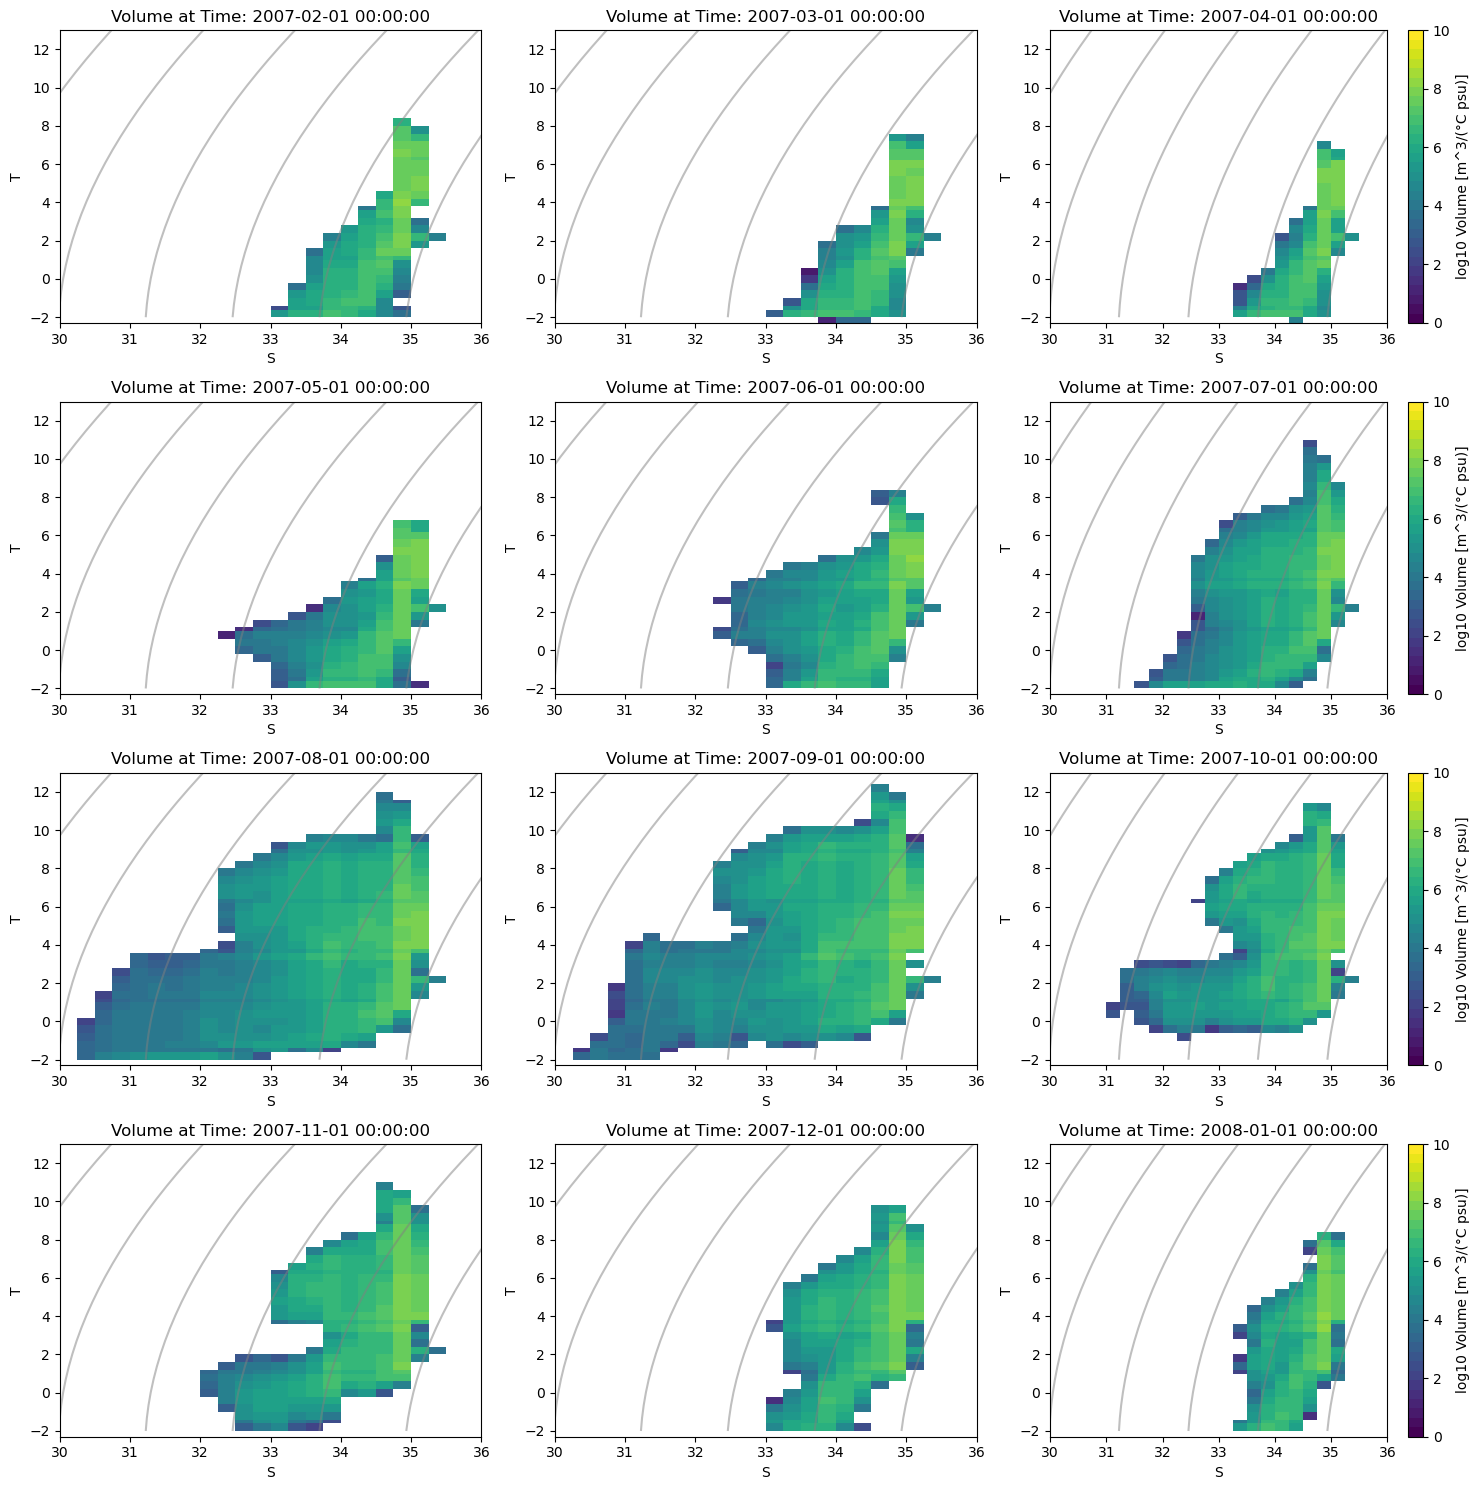

In [65]:
# setup before the run
xlims, ylims = np.array([30, 36]), np.array([-2.3, 13])

# setup the plotting
fig, axes = plt.subplots(4,3, figsize = (15,15))
axes = axes.flatten()

# loop through tsstr and plot each
i = 0  # for getting the datetimes name
for idx, ts in enumerate(tsstr):
    print(ts)
    ax = axes[idx]
    im = ax.pcolormesh(Sbin,Tbin, np.log10(vol_distrib[ts]).T,cmap=cmap2,vmin=0,vmax=10)

    ax.set_xlabel("S")
    ax.set_ylabel("T")
    ax.set_title(f"Volume at Time: {datetimes[i]}")
    #ax.grid()
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    # Add colorbar for the last row of subplots
    if idx % 3 == 2 or idx == len(tsstr) - 1:
        cbar = fig.colorbar(im, ax=ax, orientation='vertical')
        cbar.set_label("log10 Volume [m^3/(°C psu)]")

    # Density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

    i += 1

# remove unused subplots
for i in range(len(tsstr),len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig(imgpath + "monthly_volume_distribution.png",dpi=300)

# now return to the G terms and see if we can calculate and understand these

In [66]:
# try to run with all months

In [67]:
ffac=1e-6
G_T=np.array([])
metaT=parsemeta(dirrun + "diags/LAYERS/layers_3d_Ttend." + tsstr[0] + ".meta")
metaS=parsemeta(dirrun + "diags/LAYERS/layers_3d_Stend." + tsstr[0] + ".meta")
nFldsS = metaS["fldList"]
nFldsT = metaT["fldList"]

In [68]:
# metaT['fldList']  # 0, 1, 2, 7, 
metaS['fldList']   # 13, 14, 15, 16, 19, 22
a = metaS['fldList']
print(a[12],a[13],a[14],a[19],a[20],a[23])  # these are the ifldS values
# these are the total tend due to salt terms, tend due to salt surf forcing, tend due to salt horizontal diff, tend due to salt vertical diff
# ... tend due to salt horiz adv, tend due to salt vertical adv
ifldS = np.array([12,13,14,19,20,23])  # total tend, surf, hDiff, vDiff, hADV, vADV

LaSs1SLT LaSh1SLT LaSz1SLT LSha1SLT LSza1SLT LSto1SLT


In [69]:
metaT['fldList']   # 13, 14, 15, 16, 19, 22
a = metaT['fldList']
print(a[0],a[1],a[2],a[7],a[8],a[11])
ifldT = np.array([0,1,2,7,8,11])    # surf, hDiff, vDiff, hADV, vADV, total tend

LaTs2TH LaTh2TH LaTz2TH LTha2TH LTza2TH LTto2TH


In [70]:
setTtend=np.array(nFldsT.copy())
setStend=np.array(nFldsS.copy())

In [71]:
print(setTtend[ifldT])
print()
print(setTtend)
print()
# print(setStend[ifldS])
for i in range(len(ifldT)-1, -1, -1):
    print(i)
    print(setTtend[ifldT[i]])

['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']

['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'TzKp2TH' 'TzRe2TH' 'TzBg2TH' 'TKpg2TH'
 'LTha2TH' 'LTza2TH' 'LTBh2TH' 'LTBz2TH' 'LTto2TH' 'LaTs1SLT' 'LaTh1SLT'
 'LaTz1SLT' 'TzKp1SLT' 'TzRe1SLT' 'TzBg1SLT' 'TKpg1SLT' 'LTha1SLT'
 'LTza1SLT' 'LTBh1SLT' 'LTBz1SLT' 'LTto1SLT']

5
LTto2TH
4
LTza2TH
3
LTha2TH
2
LaTz2TH
1
LaTh2TH
0
LaTs2TH


In [72]:
# iwetC2d
# iwet_BarentsS2D
# rac2d.shape
# print(iwetC2d[iwet_BarentsS2D])
# print(iwet_BarentsS2D)
print(nx,ny,nT)
a = 40459500
print(a/(nx*ny))

270 1350 112
111.0


In [76]:
# make the G_T term
G_T = {}
G_T[nbasin] = {}
    
# now loop through each timestep in tsstr
for t in tsstr:
    print(t)
    # initialize for the timestep
    G_T[nbasin][t] = {}
    residT = None

    # loop through each ifldT backward (total tend, vADV, hADV, vDiff, hDiff, surface)
    for i in range(len(ifldT)-1, -1, -1):
        # read from the file for current timestep
        tmp = read_float32_skip(dirrun + f"diags/LAYERS/layers_3d_Ttend.{t}.data", nx*ny*(nT-1), ifldT[i])
        tmp = np.reshape(tmp,(nT-1,nx*ny))

        # apply masking and rescale with ffac
        tmp = tmp[:,iwetC2d] * (rac2dtile * hf2dtile) * ffac

        # update residual
        if i == ifldT.shape[0]-1:  # for total tendency, leave as is
            residT = tmp
        else:                      # for all other terms, remove from the residual
            residT = residT-tmp
    
        # just do the Barents Sea for this one
        a = np.nansum(tmp[:,iwet_BarentsS2D],axis=1)
        G_T[nbasin][t][setTtend[ifldT[i]]] = a

    # compute and store the residual for this timestep
    G_T[nbasin][t]["residT"] = np.nansum(residT[:,iwet_BarentsS2D],axis=1)

0000267408
0000271440
0000275904
0000280224
0000284688
0000289008
0000293472
0000297936
0000302256
0000306720
0000311040
0000315504


In [77]:
# # save G_T to file
# matpath = "/scratch2/mmurakami/aste_270x450x180/"
# matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
# np.savez_compressed(matpath + "G_T_BarentsS.npz", **G_T[nbasin])
# print("Saved vol_distrib as .npz")

Saved vol_distrib as .npz


In [78]:
print(setStend[ifldS])
print()
print(setStend)
print()
# print(setStend[ifldS])
for i in range(len(ifldS)-1, -1, -1):
    print(i)
    print(setStend[ifldS[i]])

['LaSs1SLT' 'LaSh1SLT' 'LaSz1SLT' 'LSha1SLT' 'LSza1SLT' 'LSto1SLT']

['LaSs2TH' 'LaSh2TH' 'LaSz2TH' 'SzKp2TH' 'SzRe2TH' 'SzBg2TH' 'SKpg2TH'
 'LSha2TH' 'LSza2TH' 'LSBh2TH' 'LSBz2TH' 'LSto2TH' 'LaSs1SLT' 'LaSh1SLT'
 'LaSz1SLT' 'SzKp1SLT' 'SzRe1SLT' 'SzBg1SLT' 'SKpg1SLT' 'LSha1SLT'
 'LSza1SLT' 'LSBh1SLT' 'LSBz1SLT' 'LSto1SLT']

5
LSto1SLT
4
LSza1SLT
3
LSha1SLT
2
LaSz1SLT
1
LaSh1SLT
0
LaSs1SLT


In [79]:
ifldS

array([12, 13, 14, 19, 20, 23])

In [ ]:
# make the G_S term
# this loop will be different because terms in different order (i=0) will be the total tend
G_S = {}
G_S[nbasin] = {}

# loop through the timesteps as above
for t in tsstr:
    print(t)
    # initialize for the timestep
    G_S[nbasin][t] = {}
    residS = None

    # now loop through similar to ifldS -  change the looping because total tend is at the end
    for i in range(len(ifldS)-1, -1, -1):
        # read the file
        tmp = read_float32_skip(dirrun + f"diags/LAYERS/layers_3d_Stend.{t}.data", nx*ny*(nT-1),ifldS[i])
        tmp = np.reshape(tmp,(nS-1,nx*ny))

        # apply masking
        tmp = tmp[:,iwetC2d] * (rac2dtile * hf2dtile) * ffac

        # update the terms
        if i == ifldS.shape[0]-1:
            residS = tmp          # for total tendency
        else:
            residS = residS-tmp   # for all other terms, remove from residual
    
        # just do for the Barents Sea
        a = np.nansum(tmp[:,iwet_BarentsS2D],axis=1)
        G_S[nbasin][t][setStend[ifldS[i]]] = a
    
    # loop through again to calculate resid
    G_S[nbasin][t]["residS"] = np.nansum(residS[:,iwet_BarentsS2D],axis=1)  # check if this axis is correct

In [ ]:
# # save G_S to file
# matpath = "/scratch2/mmurakami/aste_270x450x180/"
# matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
# G_S_array = {key: np.array(value) for key, value in G_S[nbasin].items()}
# np.savez_compressed(matpath + "G_S_BarentsS.npz", **G_S_array)
# print("Saved vol_distrib as .npz")

# load these G terms from file to prove that we can do that

In [80]:
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
loaded = np.load(matpath + "G_S_BarentsS.npz", allow_pickle=True)
# G_S = dict(loaded)
G_S = {key: loaded[key].item() for key in loaded}
G_S['0000267408'].keys()

dict_keys(['LSto1SLT', 'LSza1SLT', 'LSha1SLT', 'LaSz1SLT', 'LaSh1SLT', 'LaSs1SLT', 'residS'])

In [81]:
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
loaded = np.load(matpath + "G_T_BarentsS.npz", allow_pickle=True)
G_T = {key: loaded[key].item() for key in loaded}
G_T['0000267408'].keys()

dict_keys(['LTto2TH', 'LTza2TH', 'LTha2TH', 'LaTz2TH', 'LaTh2TH', 'LaTs2TH', 'residT'])

In [94]:
# get the indices we want to plot - only need one sample array
sampleS = G_S[mytime]['LSto1SLT']
nonzer_indices = np.flatnonzero(sampleS)
ibegS = nonzer_indices[0]
iendS = nonzer_indices[-1]
iiS = np.arange(ibegS-5,iendS+5)

# do same index sampling for G_T
sampleT = G_T[mytime]['LTto2TH']
nonzer_indices = np.flatnonzero(sampleT)
ibegT = nonzer_indices[0]
iendT = nonzer_indices[-1]
iiT = np.arange(ibegT-1,iendT+2)

print(iiS.shape,iiT.shape)
iiS

(17,) (31,)


array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96])

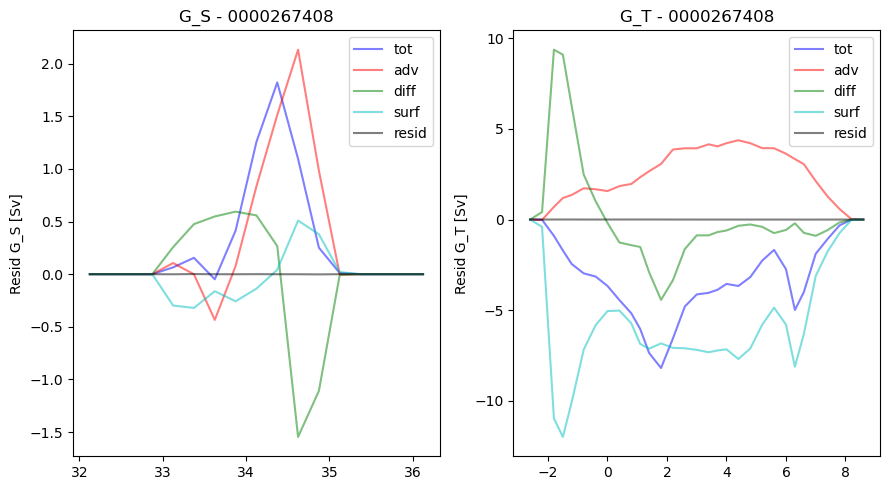

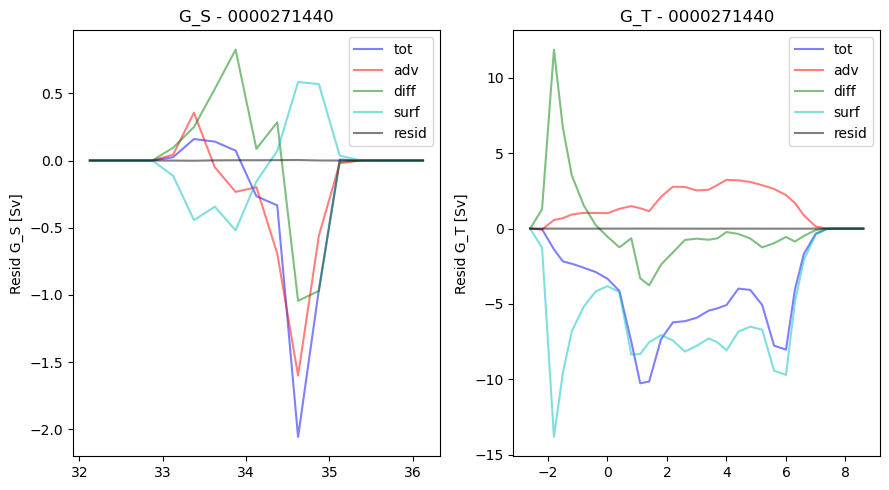

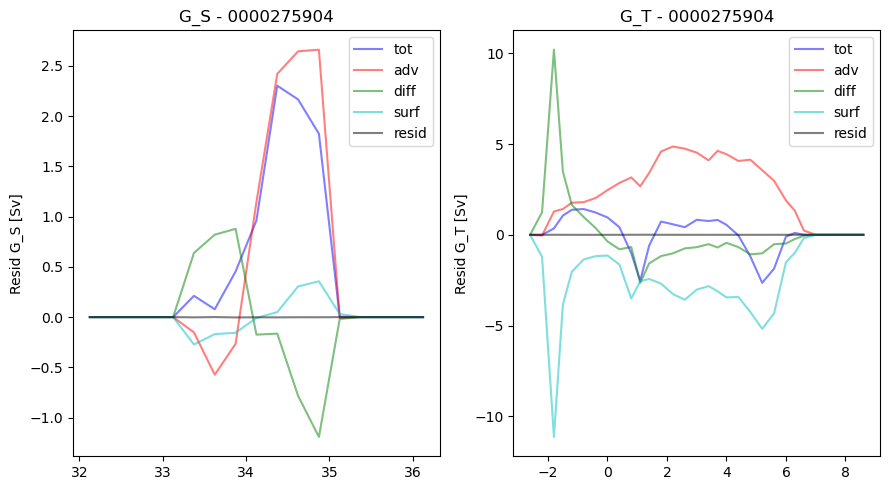

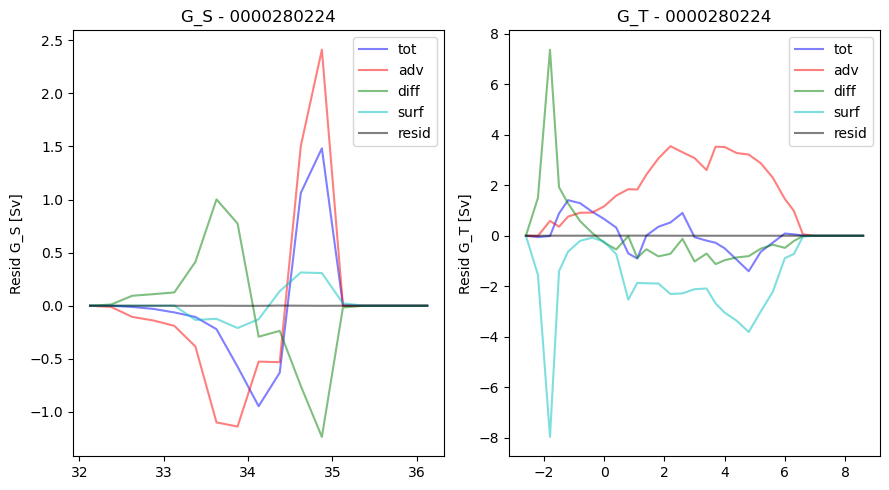

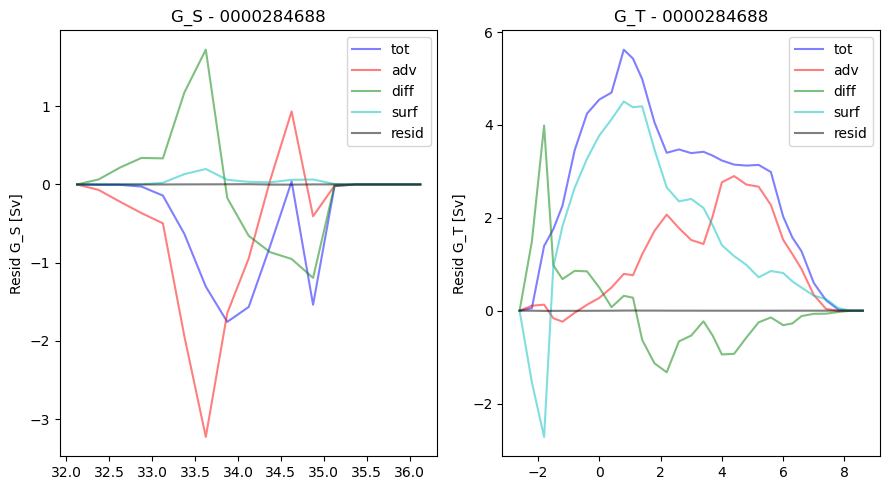

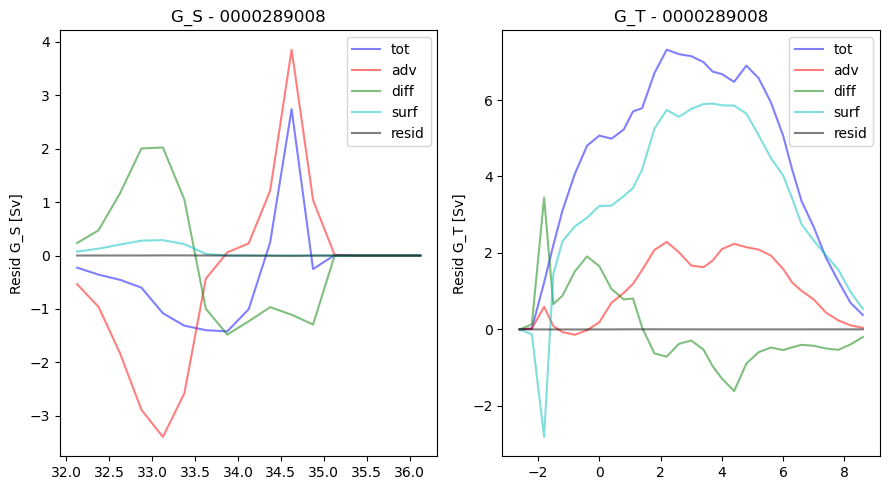

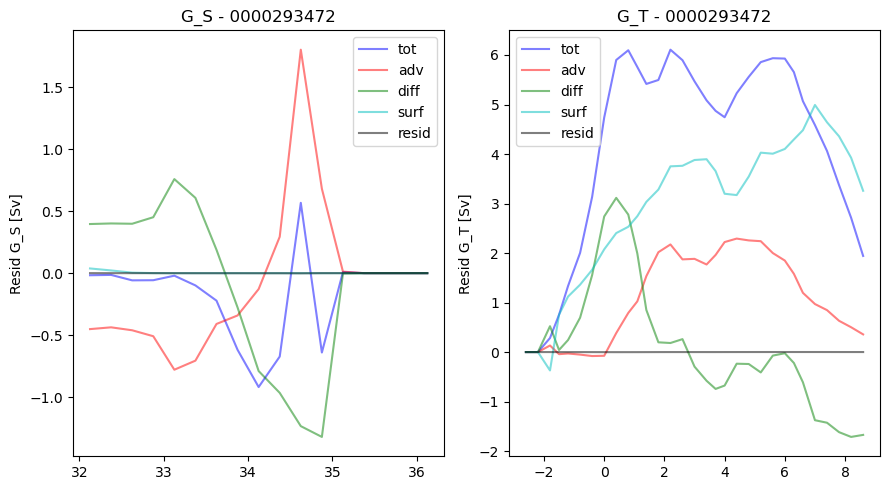

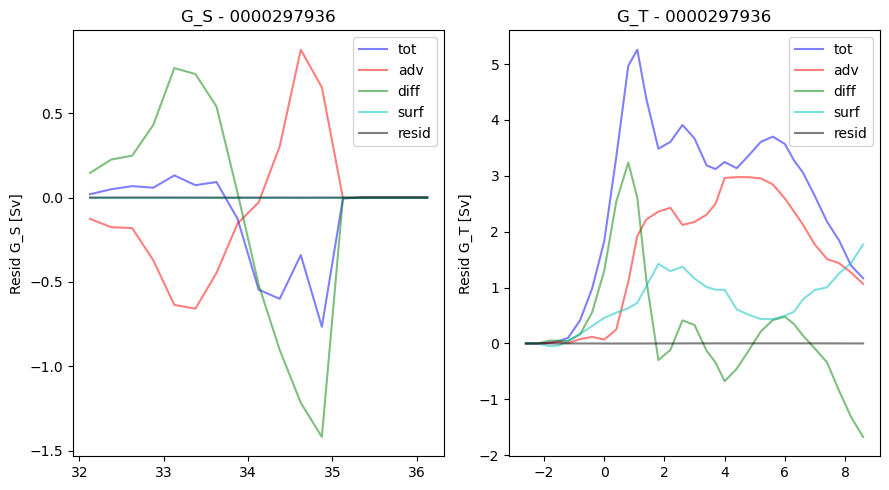

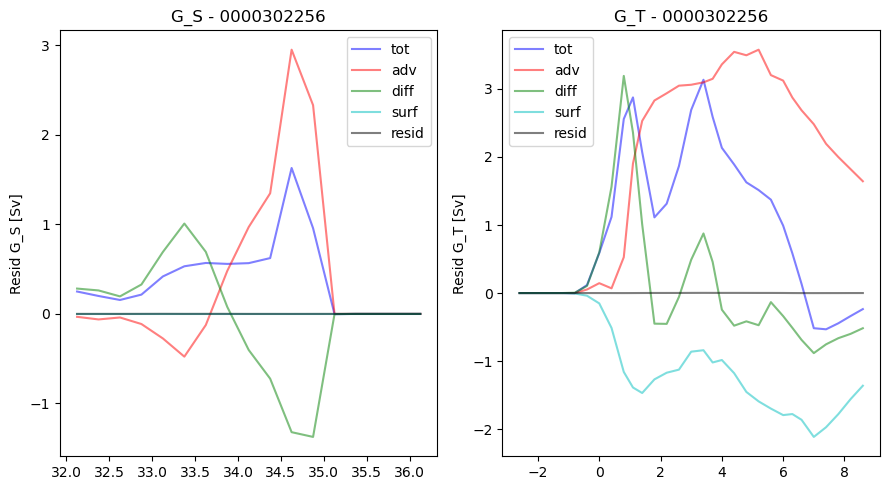

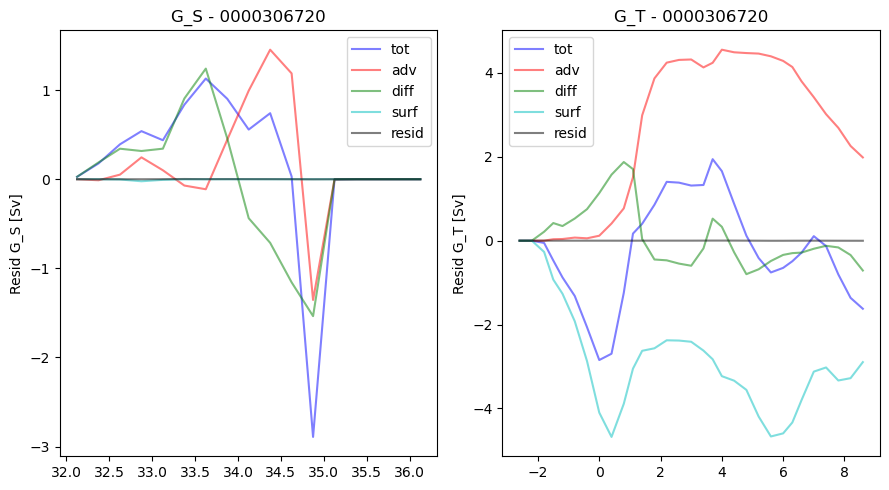

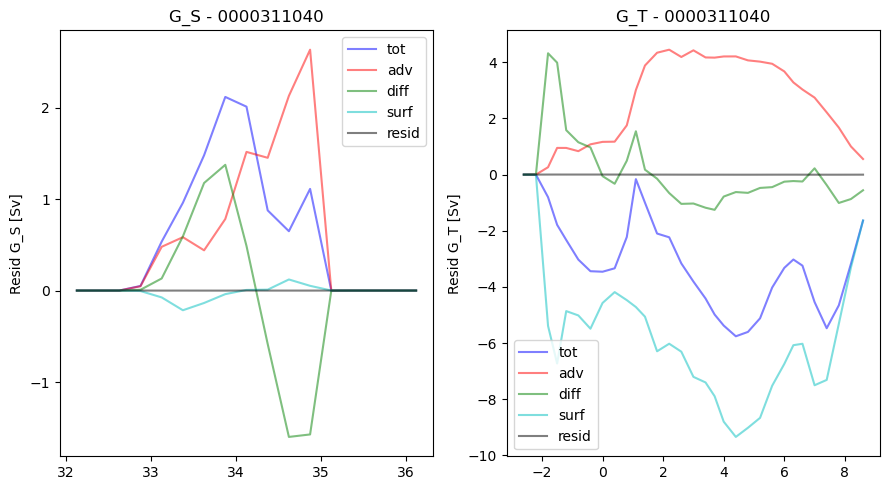

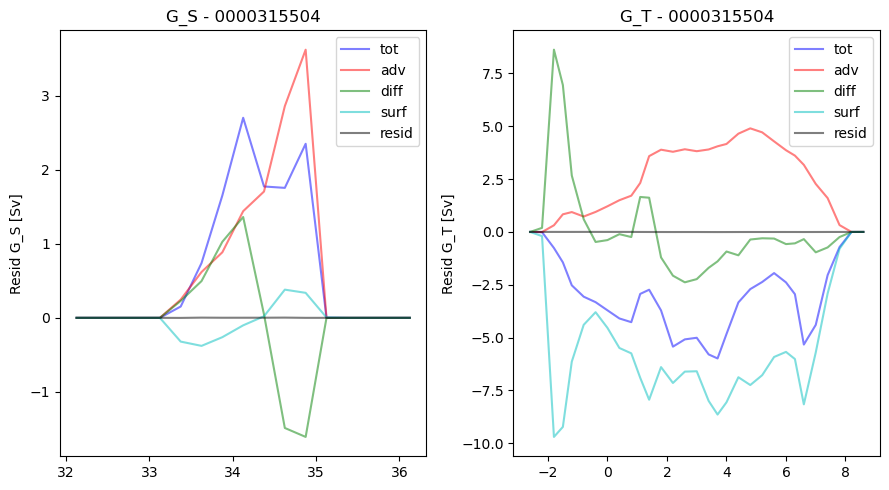

In [96]:
# plot all the available times

# Loop through the first 24 keys of G_T
for i, mytime in enumerate(list(G_T.keys())[:24]):
    fig = plt.figure(figsize=(9, 5))

    ax1 = plt.subplot(121)
    ax1.plot(binmidS[iiS], G_S[mytime]["LSto1SLT"][iiS], 'b-', alpha=0.5, label="tot")
    ax1.plot(binmidS[iiS], G_S[mytime]["LSza1SLT"][iiS] + G_S[mytime]["LSha1SLT"][iiS], 'r-', alpha=0.5, label="adv")
    ax1.plot(binmidS[iiS], G_S[mytime]["LaSz1SLT"][iiS] + G_S[mytime]["LaSh1SLT"][iiS], 'g-', alpha=0.5, label="diff")
    ax1.plot(binmidS[iiS], G_S[mytime]["LaSs1SLT"][iiS], 'c-', alpha=0.5, label="surf")
    ax1.plot(binmidS[iiS], G_S[mytime]["residS"][iiS], 'k-', alpha=0.5, label="resid")
    ax1.legend(loc="best")
    ax1.set_title(f"G_S - {mytime}")
    ax1.set_ylabel('Resid G_S [Sv]')


    ax2 = plt.subplot(122)
    ax2.plot(binmidT[iiT], G_T[mytime]["LTto2TH"][iiT], 'b-', alpha=0.5, label="tot")
    ax2.plot(binmidT[iiT], G_T[mytime]["LTza2TH"][iiT] + G_T[mytime]["LTha2TH"][iiT], 'r-', alpha=0.5, label="adv")
    ax2.plot(binmidT[iiT], G_T[mytime]["LaTz2TH"][iiT] + G_T[mytime]["LaTh2TH"][iiT], 'g-', alpha=0.5, label="diff")
    ax2.plot(binmidT[iiT], G_T[mytime]["LaTs2TH"][iiT], 'c-', alpha=0.5, label="surf")
    ax2.plot(binmidT[iiT], G_T[mytime]["residT"][iiT], 'k-', alpha=0.5, label="resid")
    ax2.legend(loc="best")
    ax2.set_title(f"G_T - {mytime}")
    ax2.set_ylabel('Resid G_T [Sv]')


    plt.tight_layout()


    # save each figure to show An
    plt.savefig(imgpath + "monthly_G_terms_" + mytime+ ".png",dpi=300)
    
    plt.show()

In [45]:
imgpath

'/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/Layers/figs/'

In [46]:
tsstr[10]
mytime = tsstr[9]

# double checking that this is closed

In [97]:
mytime = tsstr[5]
G_T

{'0000267408': {'LTto2TH': array([ 0.00000000e+00, -1.11848684e-02, -8.98674771e-01, -1.70341040e+00,
         -2.45543907e+00, -2.96539825e+00, -3.13947448e+00, -3.66103052e+00,
         -4.43591140e+00, -5.16690246e+00, -6.03419917e+00, -7.35690229e+00,
         -8.18393210e+00, -6.55426716e+00, -4.79212346e+00, -4.12783486e+00,
         -4.03909586e+00, -3.87100765e+00, -3.54654789e+00, -3.66175487e+00,
         -3.17264614e+00, -2.26420237e+00, -1.67388551e+00, -2.73782036e+00,
         -4.98623750e+00, -3.99702355e+00, -1.88418948e+00, -1.06849205e+00,
         -3.21762266e-01, -1.47616491e-03,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000

Text(0.5, 1.0, 'G_T')

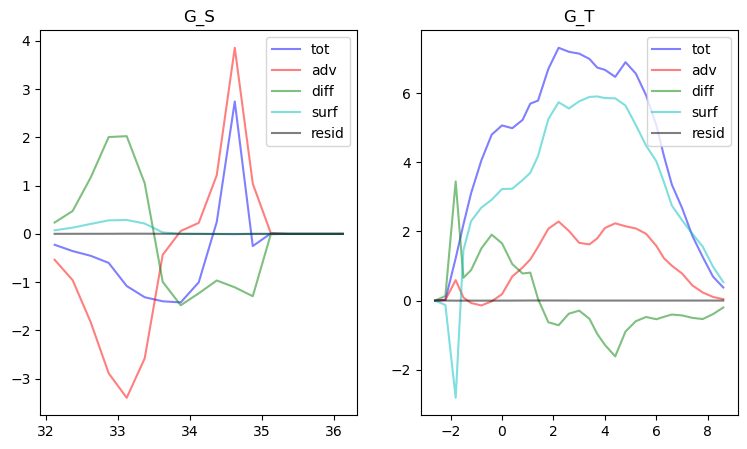

In [99]:
fig = plt.figure(figsize = (9,5))

ax = plt.subplot(121)
ax.plot(binmidS[iiS], G_S[mytime]["LSto1SLT"][iiS], 'b-', alpha=0.5,label="tot")
ax.plot(binmidS[iiS], G_S[mytime]["LSza1SLT"][iiS] + G_S[mytime]["LSha1SLT"][iiS], 'r-', alpha=0.5,label="adv")
ax.plot(binmidS[iiS], G_S[mytime]["LaSz1SLT"][iiS] + G_S[mytime]["LaSh1SLT"][iiS], 'g-', alpha=0.5,label="diff")
ax.plot(binmidS[iiS], G_S[mytime]["LaSs1SLT"][iiS], 'c-', alpha=0.5,label="surf")
ax.plot(binmidS[iiS], G_S[mytime]["residS"][iiS], 'k-', alpha=0.5,label="resid")
ax.legend(loc="best")
ax.set_title("G_S")


ax = plt.subplot(122)
ax.plot(binmidT[iiT], (G_T[mytime]["LTto2TH"][iiT]), 'b-', alpha=0.5,label="tot")
ax.plot(binmidT[iiT], G_T[mytime]["LTza2TH"][iiT] + G_T[mytime]["LTha2TH"][iiT], 'r-', alpha=0.5,label="adv")
ax.plot(binmidT[iiT], G_T[mytime]["LaTz2TH"][iiT] + G_T[mytime]["LaTh2TH"][iiT], 'g-', alpha=0.5,label="diff")
ax.plot(binmidT[iiT], G_T[mytime]["LaTs2TH"][iiT], 'c-', alpha=0.5,label="surf")
ax.plot(binmidT[iiT], G_T[mytime]["residT"][iiT], 'k-', alpha=0.5,label="resid")
ax.legend(loc="best")
ax.set_title("G_T")

In [100]:
a = G_S[mytime]["LSto1SLT"]
b = G_S[mytime]["LSza1SLT"] + G_S[mytime]["LSha1SLT"]
c = G_S[mytime]["LaSz1SLT"] + G_S[mytime]["LaSh1SLT"]
d = G_S[mytime]["LaSs1SLT"]
e = G_S[mytime]["residS"]

# now try to make the J terms for one month

In [101]:
# metaT=parsemeta(dirdiags + "LAYERS/layers_3d_Ttend.0000723024.meta")

# set 1 - the total terms we want for the budget
setTS_Ttend=parsemeta(dirrun + "diags/LAYERS_Cwet/layers_TSjoint_Ttend_set1_146614.0000315504.meta")["fldList"]

# set 2 - the other terms
setTS_Ttend_set2=parsemeta(dirrun + "diags/LAYERS_Cwet/layers_TSjoint_Ttend_set2_146614.0000315504.meta")["fldList"]

# set 1 - the total terms for the salt budget
setTS_Stend=parsemeta(dirrun + "diags/LAYERS_Cwet/layers_TSjoint_Stend_set1_146614.0000315504.meta")["fldList"]

# set 2 - the other terms
setTS_Stend_set2=parsemeta(dirrun + "diags/LAYERS_Cwet/layers_TSjoint_Stend_set2_146614.0000315504.meta")["fldList"]

In [102]:
setTS_Ttend

['LaTs_TS', 'LaTh_TS', 'LaTz_TS', 'LTha_TS', 'LTza_TS', 'LTto_TS']

In [103]:
setTS_Stend

['LaSs_TS', 'LaSh_TS', 'LaSz_TS', 'LSha_TS', 'LSza_TS', 'LSto_TS']

In [104]:
nbasin

'BarentsS'

In [ ]:
# do the Jy term
# DO NOT RUN IF HAS ALREADY BEEN CALCULATED
# JUST FOR SET1 HERE - NOT FOR SET 2
# 287 - should be indexing nt, ns, wetpoints
# T, S, wetpoints
Jy = {}
# set each basin to its own dictionary
Jy[nbasin] = {}
Jy[nbasin]['G_T'] = {}
Jy[nbasin]['G_T']['residT'] = {}

rac = mygrid['RAC']
hf1 = hf1.reshape(ny,nx)

for i in range(len(setTS_Ttend)-1, -1, -1):
    t0 = time.localtime()
    # CHECK THIS IS SHAPED CORRECTLY - HOW
    filename = dirrun + "diags/LAYERS_Cwet/layers_TSjoint_Ttend_set1_" + str(LwetC2d) + "." + tsstr[0] + ".data"
    tmp = read_float32_skip(filename, LwetC2d*(nS-1)*(nT-1),i)
    tmp = np.reshape(tmp,(nT-1,nS-1,LwetC2d))
    print(tmp.shape)

    small = rac2d * hf2d
    tmp = tmp * np.tile(small[np.newaxis,np.newaxis,:], (nT - 1, nS - 1,1)) * ffac

    # if at end of loop
    if i == len(setTS_Ttend)-1:
        f = (np.nansum(tmp, axis=2))
        f = np.nansum(f * binwidthS1)

    # double check the names in the listed file
    if i == len(setTS_Ttend)-1:
        # do not remove from the residual - this is the total tendency
        residT = tmp
    elif i==0 or i == 1 or i == 2 or i == 3 or i == 4:
        # LaTs_TS LaTh_TS LaTz_TS LTha_TS LTza_TS (LTBh_TS)
        # surface forcing, hDiff, vDiff, hADV, vADV, hADV bolus
        residT = residT - tmp

    tmp1 = np.nansum(tmp[:,:,iwet_BarentsS2D],axis=2)   # SUM OVER WET POINTS - should be of shape nS-1, nT-1
    # TEST:
    # tmp1 = tmp1.T
    tmp2 = np.nansum(tmp1 * binwidthS1,axis=1)              # SUM OVER S - should be of shape nT-1
    Jy[nbasin][setTS_Ttend[i]] = tmp1
    Jy[nbasin]['G_T'][setTS_Ttend[i]] = tmp2
    del tmp
    del tmp1
    del tmp2


myresid = np.nansum(residT[:,:,iwet_BarentsS2D],axis=2)    # SUM OVER WET POINTS - should be of shape nS-1, nT-1
# myresid = myresid.T
Jy[nbasin]["residT"] = myresid
Jy[nbasin]["G_T"]["residT"] = np.nansum(Jy[nbasin]["residT"] * binwidthS1,axis=1)   #SUM OVER S - should be of shape nT-1

# set units and labels
Jy["unit"] = "m/s/psu"

# Define your filename
filename = "Jy_data.npz"
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"

# Save the dictionary
np.savez(matpath + filename, **Jy)

In [106]:
# Load the .npz file
filename = "Jy_data.npz"
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"

loaded_data = np.load(matpath + filename, allow_pickle=True)

# Convert it back to a dictionary
Jy_loaded = {key: loaded_data[key].item() if loaded_data[key].ndim == 0 else loaded_data[key] for key in loaded_data}
# Jy_loaded

In [28]:
# DO NOT RUN IF HAS ALREADY BEEN CALCULATED
Jx = {}
# set each basin to its own dictionary
Jx[nbasin] = {}
Jx[nbasin]['G_S'] = {}
Jx[nbasin]['G_S']['residS'] = {}

rac = mygrid['RAC']
hf1 = hf1.reshape(ny,nx)

for i in range(len(setTS_Stend)-1, -1, -1):
    filename = dirrun + "diags/LAYERS_Cwet/layers_TSjoint_Stend_set1_" + str(LwetC2d) + "." + tsstr[0]+ ".data"
    tmp = read_float32_skip(filename, LwetC2d*(nS-1)*(nT-1),i)
    tmp = np.reshape(tmp,(nT-1,nS-1,LwetC2d))
    print(tmp.shape)

    small = rac2d * hf2d
    tmp = tmp * np.tile(small[np.newaxis,np.newaxis,:], (nT - 1, nS - 1,1)) * ffac

    if i == len(setTS_Stend)-1:
        # LSto_TS - total tendency
        residS = tmp
    elif i==0 or i == 1 or i == 2 or i == 3 or i == 4:
        # LaSs_TS LaSh_TS LaSz_TS LSha_TS LSza_TS LSBh_TS
        # surface, hdiff, vdiff, hADV, vADV, hADV bolus
        residS = residS - tmp

    # use stri_wet, strb is names of basins
    tmp1 = np.nansum(tmp[:,:,iwet_BarentsS2D],axis=2)   # should be of shape nS-1, nT-1
    # TEST
    # tmp1 = tmp1.T
    thisbinwidthT1 = np.tile(binwidthT1[:,np.newaxis],(1, nS - 1))
    tmp2 = np.nansum(tmp1 * thisbinwidthT1, axis=1)                 # second dim is T because this is S tend
    Jx[nbasin][setTS_Stend[i]] = tmp1
    Jx[nbasin]['G_S'][setTS_Stend[i]] = tmp2
    del tmp
    del tmp1
    del tmp2

tmp1 = np.nansum(residS[:,:,iwet_BarentsS2D],axis=2)    # sum over geo space
mytileT1 = np.tile(binwidthT1[np.newaxis,:],(nS-1,1))  # nS-1 x nT-1
# TEST
# mytileT1 = mytileT1.T
tmp2 = np.nansum(tmp1 * mytileT1, axis=0)     # sum over T ( dimension 0)
Jx[nbasin]["residS"] = tmp1    # should be of shape nS-1, nT-1
Jx[nbasin]["G_S"]["residS"] = tmp2 #should be of shape nT-1

# set units and labels
Jx["descr"] = "m/s/degC"

# Define your filename
filename = "Jx_data.npz"
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"

# Save the dictionary
np.savez(matpath + filename, **Jx)

(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)


In [108]:
# Load the .npz file
loaded_data = np.load(matpath + filename, allow_pickle=True)

# Convert it back to a dictionary
Jx_loaded = {key: loaded_data[key].item() if loaded_data[key].ndim == 0 else loaded_data[key] for key in loaded_data}
# Jx_loaded

# load Jy from previous and plot in 2D to see if we did it

In [109]:
vol_distrib.keys()

dict_keys(['0000267408', '0000271440', '0000275904', '0000280224', '0000284688', '0000289008', '0000293472', '0000297936', '0000302256', '0000306720', '0000311040', '0000315504'])

(0.0, 40.0)

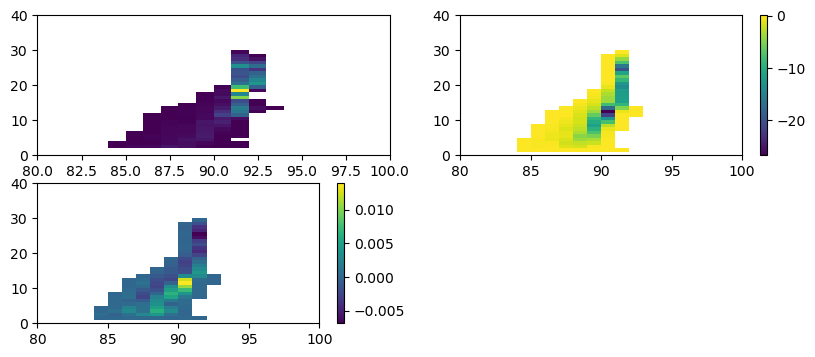

In [110]:
fig = plt.figure()

ax = plt.subplot(221)
# ax.pcolormesh(vol_distrib['0000271440'])
ax.pcolormesh(vol_distrib['0000267408'])
ax.set_xlim(80,100)
ax.set_ylim(0,40)

ax = plt.subplot(222)
a = Jy_loaded[nbasin]["LTto_TS"]
a[a==0] = np.nan
cb = ax.pcolormesh(a)
plt.colorbar(cb)
ax.set_xlim(80,100)
ax.set_ylim(0,40)

ax = plt.subplot(223)
a = Jy_loaded[nbasin]["residT"]
a[a==0] = np.nan
cb = ax.pcolormesh(a)
plt.colorbar(cb)
ax.set_xlim(80,100)
ax.set_ylim(0,40)

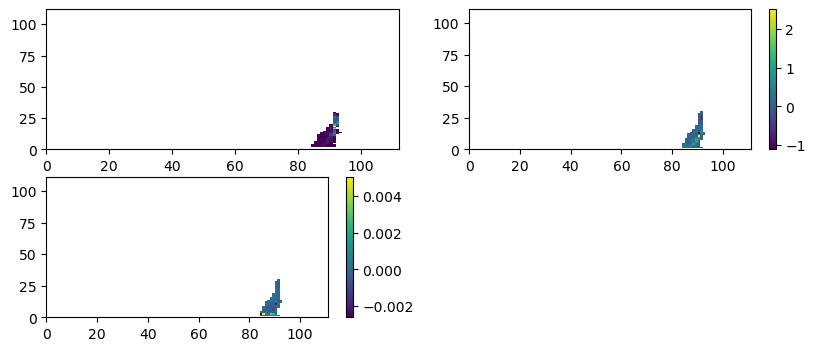

In [112]:
fig = plt.figure()

ax = plt.subplot(221)
ax.pcolormesh(vol_distrib['0000267408'])

ax = plt.subplot(222)
a = Jx_loaded[nbasin]["LSto_TS"]
a[a==0] = np.nan
cb = ax.pcolormesh(a)
plt.colorbar(cb)

ax = plt.subplot(223)
a = Jx_loaded[nbasin]["residS"]
a[a==0] = np.nan
cb = ax.pcolormesh(a)
plt.colorbar(cb)

In [119]:
# Jx_loaded.keys()
# Jx_loaded[nbasin]['LSto_TS']
# Sbint,Tbint = np.meshgrid(binmidS[:-1],binmidT[:-1])
Sbin2.shape
Jx_loaded[nbasin]['LSto_TS'].shape

(111, 111)

In [90]:
Jy_loaded[nbasin].keys()

dict_keys(['G_T', 'LTto_TS', 'LTza_TS', 'LTha_TS', 'LaTz_TS', 'LaTh_TS', 'LaTs_TS', 'residT'])

In [92]:
Jx_loaded[nbasin].keys()

dict_keys(['G_S', 'LSto_TS', 'LSza_TS', 'LSha_TS', 'LaSz_TS', 'LaSh_TS', 'LaSs_TS', 'residS'])

In [125]:
U1,V1 = Jx_loaded[nbasin]['LSto_TS'], Jy_loaded[nbasin]['LTto_TS']
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
print(U1.shape,V1.shape)
print(Sbin2.shape,Tbin2.shape)

(111, 111) (111, 111)
(111, 111) (111, 111)


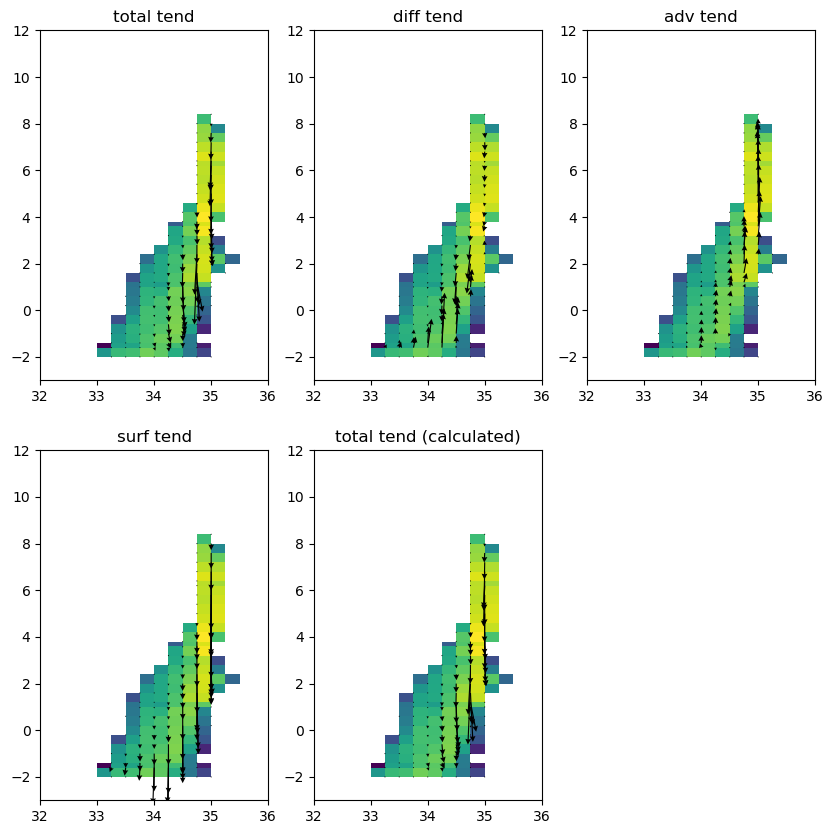

In [137]:
fig = plt.figure(figsize = (10,10))


# first subplot - total tendency
ax = plt.subplot(231)
ax.pcolormesh(Sbin,Tbin,np.log10(vol_distrib['0000267408']).T)
# set the quivers
U1,V1 = Jx_loaded[nbasin]['LSto_TS'].T, Jy_loaded[nbasin]['LTto_TS'].T
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
q = ax.quiver(Sbin2, Tbin2, U1, V1, width=0.005, zorder=3, headwidth=5,scale=1e2)
ax.set_xlim(32,36)
ax.set_ylim(-3,12)
ax.set_title("total tend")

# second subplot - adv tendency
ax = plt.subplot(232)
ax.pcolormesh(Sbin,Tbin,np.log10(vol_distrib['0000267408']).T)
# set the quivers
U1,V1 = Jx_loaded[nbasin]['LaSz_TS'].T + Jx_loaded[nbasin]['LaSh_TS'].T, Jy_loaded[nbasin]['LaTz_TS'].T + Jy_loaded[nbasin]['LaTh_TS'].T
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
q = ax.quiver(Sbin2, Tbin2, U1, V1, width=0.005, zorder=3, headwidth=5,scale=1e2)
ax.set_xlim(32,36)
ax.set_ylim(-3,12)
ax.set_title("diff tend")

# third subplot - adv tendency
ax = plt.subplot(233)
ax.pcolormesh(Sbin,Tbin,np.log10(vol_distrib['0000267408']).T)
# set the quivers
U2,V2 = Jx_loaded[nbasin]['LSza_TS'].T + Jx_loaded[nbasin]['LSha_TS'].T, Jy_loaded[nbasin]['LTza_TS'].T + Jy_loaded[nbasin]['LTha_TS'].T
U2[U2 == 0], V2[V2 == 0] = np.nan, np.nan
q = ax.quiver(Sbin2, Tbin2, U2, V2, width=0.005, zorder=3, headwidth=5,scale=1e2)
ax.set_xlim(32,36)
ax.set_ylim(-3,12)
ax.set_title("adv tend")

# third subplot - adv tendency
ax = plt.subplot(234)
ax.pcolormesh(Sbin,Tbin,np.log10(vol_distrib['0000267408']).T)
# set the quivers
U3,V3 = Jx_loaded[nbasin]['LaSs_TS'].T, Jy_loaded[nbasin]['LaTs_TS'].T
U3[U3 == 0], V3[V3 == 0] = np.nan, np.nan
q = ax.quiver(Sbin2, Tbin2, U3, V3, width=0.005, zorder=3, headwidth=5,scale=1e2)
ax.set_xlim(32,36)
ax.set_ylim(-3,12)
ax.set_title("surf tend")

# third subplot - total
ax = plt.subplot(235)
ax.pcolormesh(Sbin,Tbin,np.log10(vol_distrib['0000267408']).T)
# set the quivers
U4 = U1 + U2 + U3
V4 = V1 + V2 + V3
q = ax.quiver(Sbin2, Tbin2, U4, V4, width=0.005, zorder=3, headwidth=5,scale=1e2)
ax.set_xlim(32,36)
ax.set_ylim(-3,12)
ax.set_title("total tend (calculated)")

plt.savefig(imgpath + "test_tendencies_" + tsstr[0] + ".png",dpi=300)